In [1]:
import os
import sys
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from scipy.linalg import pinv
import scipy
import pydmd

from tqdm import tqdm

from sklearn.decomposition import PCA

import time

import pickle as pkl

import sys
sys.path.append('../')
from utils import *

In [2]:
def TDE_wravel(X: np.array, lag: int):
    T, N = X.shape
    X_delay = np.zeros((T-lag+1, N*lag), dtype = 'complex128')
    for l in range(lag):
        X_delay[:,l*N:(l+1)*N] = X[l:T-(lag-1)+l]
    
    return X_delay

def TDE_unwravel(X_delay: np.array, lag: int):
    T_all, N_all = X_delay.shape

    N = N_all // lag
    T = T_all+lag-1
    X = np.zeros((T, N),dtype = 'complex128')
    for t in range(T_all):
        for l in range(lag):
            X[t+l,:] = X_delay[t,l*N:(l+1)*N]
        
    return X

scenario 126 done
scenario 245 done
scenario 370 done
scenario 585 done


<Figure size 640x480 with 0 Axes>

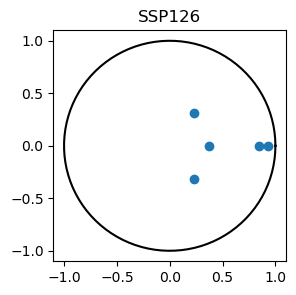

<Figure size 640x480 with 0 Axes>

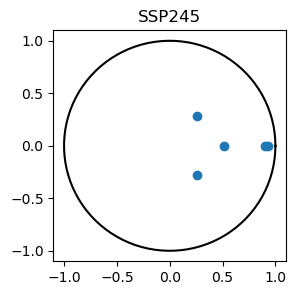

<Figure size 640x480 with 0 Axes>

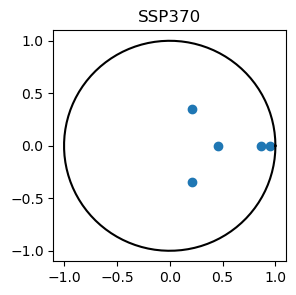

<Figure size 640x480 with 0 Axes>

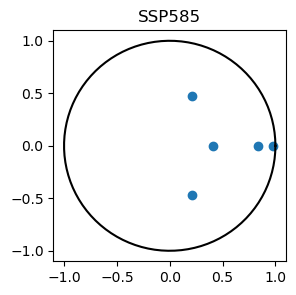

In [10]:
lag = 30
forced_means = {}
for scenario in [126, 245, 370, 585]:
    xr_train_clim = xr.open_dataset('../data/train_val/outputs_historical.nc').mean(dim='member')
    xr_test_clim = xr.open_dataset(f'../data/train_val/outputs_ssp{scenario}.nc').mean(dim='member')

    tas_all = xr.concat([xr_train_clim, xr_test_clim], dim = 'time').tas.values
    times = xr.concat([xr_train_clim, xr_test_clim], dim = 'time').time
    ntime, nlat, nlong = tas_all.shape
    tas_data = tas_all.reshape(ntime, -1)[lag-1:,:]
    
    forcing_data = np.load(f'../data/forcings/historical+ssp{scenario}_forcing.npy').T

    control_data = TDE_wravel(forcing_data, lag = lag)

    my_dmdc = pydmd.DMDc(svd_rank=5)   #(svd_rank=5) 
    my_dmdc.fit(tas_data.T, control_data[:-1,:].T)

    plt.figure()
    theta = np.linspace(0, 2*np.pi, 100)
    # Parametric equations for the unit circle
    x = np.cos(theta)
    y = np.sin(theta)
    # Plot the unit circle
    plt.figure(figsize=(3, 3))
    plt.plot(x, y, color = 'k')
    plt.scatter(np.real(my_dmdc.eigs), np.imag(my_dmdc.eigs))
    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,1.1])
    plt.title(f'SSP{scenario}')


    with open(f"../models/DMDc-hankelforcing/tas{scenario}.pkl", "wb") as file:
        pkl.dump(my_dmdc, file)

    print(f'scenario {scenario} done')
